All Packages I might need

In [1]:
import numpy as np
from numpy.random import randn

import pandas as pd
from pandas import Series, DataFrame
from pandas.plotting import scatter_matrix

import math as m

import time as t

All single-computation commands

In [17]:
MLB=pd.read_csv('MLB_Final_Results.csv')
MLB_DF=pd.DataFrame(MLB)
p_MLB=2
MLB_DF['PythagHome']=MLB_DF.apply(lambda x: x['HomeFor']**p_MLB/(x['HomeFor']**p_MLB+x['HomeAgainst']**p_MLB),axis=1)
MLB_DF['PythagAway']=MLB_DF.apply(lambda x: x['AwayFor']**p_MLB/(x['AwayFor']**p_MLB+x['AwayAgainst']**p_MLB),axis=1)
MLB_DF['Pythag']=MLB_DF.apply(lambda x: x['For']**p_MLB/(x['For']**p_MLB+x['Against']**p_MLB),axis=1)
MLB_DF['SeasRank'] = MLB_DF.groupby(['Season'])['Pythag'].rank(method='first', ascending=False)

MLB_DF.groupby('SeasRank').mean().to_csv('MLB_Averages.csv')
MLB_Averages=MLB_DF.groupby('SeasRank').mean()

HF_Avg=MLB_DF.HomeFor.mean()
HA_Avg=MLB_DF.HomeAgainst.mean()
HF_Avg,HA_Avg

MLB_Sched=pd.DataFrame(pd.read_excel('MLB_Schedule_No_Div.xlsx'))

def Sim(F,A):
    r=np.random.rand()
    p=F**p_MLB/(F**p_MLB+A**p_MLB)
    if r<p:
        return 1
    elif r>p:
        return 0
    else:
        return 0.5
    
def FullGameSim(HF,HA,AF,AA,Avg_HF,Avg_HA):
    HF_Adj=(HF*AA)/Avg_HF
    AF_Adj=(AF*HA)/Avg_HA
    g=Sim(HF_Adj,AF_Adj)
    return g,HF_Adj,AF_Adj


All iterative simulations

In [21]:
t_start=t.time()
n_sim=5000
Results=[]
for sim in range(0,n_sim):
    MLB_Ranks=pd.DataFrame(data={'TeamID':MLB_Sched['Away ID'].unique(),'TeamRank':np.random.rand(30)})
    MLB_Ranks.TeamRank=MLB_Ranks.TeamRank.rank(method='first', ascending=False) #replace randoms with ranks
    MLB_Ranks['League']=MLB_Ranks['TeamID'].str[:2] #Convert to string, grab first 2
    MLB_Ranks['Division']=MLB_Ranks['TeamID'].str[2:3] #convert to string, characters [2,3)
    MLB_Ranks=MLB_Ranks.sort_values(by=['TeamID'])

    MLB_Sched['AwayRank']=MLB_Sched.apply(lambda x: MLB_Ranks.loc[MLB_Ranks['TeamID'] == x['Away ID']].iloc[0,1] ,axis=1)
    MLB_Sched['HomeRank']=MLB_Sched.apply(lambda x: MLB_Ranks.loc[MLB_Ranks['TeamID'] == x['Home ID']].iloc[0,1] ,axis=1)

    MLB_Sched['HomeResult']=MLB_Sched.apply(lambda x: FullGameSim(
        MLB_Averages.iloc[int(x['HomeRank']-1),2]
        ,MLB_Averages.iloc[int(x['HomeRank']-1),1]
        ,MLB_Averages.iloc[int(x['AwayRank']-1),7]
        ,MLB_Averages.iloc[int(x['AwayRank']-1),8]
        ,HF_Avg,HA_Avg)[0], axis=1)

    MLB_Ranks['Result']=np.zeros(30)
    for i in range(1,31):
        MLB_Ranks.iloc[i-1,4]=(MLB_Sched.groupby('HomeRank').mean().HomeResult[MLB_Ranks.iloc[i-1,1]]+
                                   (1-MLB_Sched.groupby('AwayRank').mean().HomeResult[MLB_Ranks.iloc[i-1,1]]))/2
    MLB_Ranks['Wins']=162*MLB_Ranks['Result']
    MLB_Ranks['Losses']=162*(1-MLB_Ranks['Result'])

    MLB_Ranks['MLBRank']=MLB_Ranks.Result.rank(method='first', ascending=False)
    MLB_Ranks['LeagueRank']=MLB_Ranks.groupby('League').Result.rank(method='first', ascending=False)
    MLB_Ranks['DivRank']=MLB_Ranks.groupby(['League','Division']).Result.rank(method='first', ascending=False)
    MLB_Ranks['LeagueSeed']=np.where(MLB_Ranks.DivRank==1,0,100)+MLB_Ranks.LeagueRank
    MLB_Ranks['LeagueSeed']=MLB_Ranks.groupby('League').LeagueSeed.rank(method='first', ascending=True)
    MLB_Ranks['PlayoffResult']='None' #Say "none" for each team. Playoff teams updated later
    MLB_Ranks['Sim']=sim #save run number

    MLB_Post_Sched=pd.read_excel('MLB_playoffs2.xlsx')
    #Playoff Simulations
    MLB_Post_Sched['Result']=np.NAN

    #Set up seeds
    if MLB_Ranks.loc[(MLB_Ranks.League=='NL')&(MLB_Ranks.LeagueSeed==1)].iloc[0,7]==1: #Higher Seed is NL
        MLB_Post_Sched.HigherSeedID=MLB_Ranks.loc[(MLB_Ranks.League=='NL')&
            (MLB_Ranks.LeagueSeed==1)].iloc[0,0] 
        MLB_Post_Sched.LowerSeedID=MLB_Ranks.loc[(MLB_Ranks.League=='AL')&
            (MLB_Ranks.LeagueSeed==1)].iloc[0,0] 
    else: #Higher Seed is AL
        MLB_Post_Sched.HigherSeedID=MLB_Ranks.loc[(MLB_Ranks.League=='AL')&
            (MLB_Ranks.LeagueSeed==1)].iloc[0,0] 
        MLB_Post_Sched.LowerSeedID=MLB_Ranks.loc[(MLB_Ranks.League=='NL')&
            (MLB_Ranks.LeagueSeed==1)].iloc[0,0]

    #WS
    HighRank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[0,6]].iloc[0,1] #Higher Seed Rank
    LowRank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[0,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(0,17):
        if MLB_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                MLB_Averages.iloc[int(HighRank-1),2]
                ,MLB_Averages.iloc[int(HighRank-1),1]
                ,MLB_Averages.iloc[int(LowRank-1),7]
                ,MLB_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                MLB_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                MLB_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                MLB_Averages.iloc[int(LowRank-1),2]
                ,MLB_Averages.iloc[int(LowRank-1),1]
                ,MLB_Averages.iloc[int(HighRank-1),7]
                ,MLB_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                MLB_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                MLB_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==9: #Best of 17
            MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,7],'PlayoffResult']='WS' #Lower seed loses WS
            MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,6],'PlayoffResult']='Champ' #Higher seed wins WS
            break
        elif LowerSeriesScore==9:
            MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,6],'PlayoffResult']='WS' #Higher seed loses WS
            MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,7],'PlayoffResult']='Champ' #Lower seed wins WS
            break
            
    #Append the results array
    if sim==0:
        Results=MLB_Ranks
    else:
        Results=Results.append(MLB_Ranks)

t_total=t.time()-t_start
t_total

10558.937043428421

<AxesSubplot:>

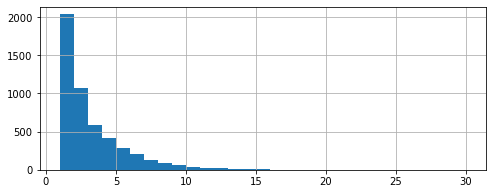

In [23]:
Results.loc[Results.PlayoffResult=='Champ'].TeamRank.hist(bins=range(1,31),xlabelsize=10,figsize=(8,3))

In [22]:
Results.to_csv('MLB_Simulation_Results2.csv')